In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import copy
import socket
from tqdm import tqdm
import torch
import pickle
from torch import optim
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter

import numpy as np
from mxnet import nd as mnd
import heapq

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))
from libs import fl, nn, agg, data, poison, log, sim, resnet

In [2]:
# Save Logs To File (info | debug | warning | error | critical) [optional]
log.init("debug")
#log.init("info", "federated.log")
#log.init("debug", "flkafka.log")

In [3]:
class FedArgs():
    def __init__(self):
        self.num_clients = 50
        self.epochs = 10
        self.local_rounds = 1
        self.client_batch_size = 32
        self.test_batch_size = 128
        self.learning_rate = 1e-4
        self.weight_decay = 1e-5
        self.cuda = True
        self.seed = 1
        self.tb = SummaryWriter('../../out/runs/federated/FLTrust', comment="Mnist Centralized Federated training")

fedargs = FedArgs()

In [4]:
use_cuda = fedargs.cuda and torch.cuda.is_available()
torch.manual_seed(fedargs.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [5]:
print(torch.cuda.is_available())

False


In [6]:
host = socket.gethostname()
clients = [host + "(" + str(client + 1) + ")" for client in range(fedargs.num_clients)]

In [7]:
#Initialize Global and Client models
#global_model = nn.ModelMNIST()
global_model = resnet.ResNet18()
client_models = {client: copy.deepcopy(global_model) for client in clients}

# Function for training
def train_model(_model, train_loader, fedargs, device):
    model, loss = fl.client_update(_model,
                                train_loader,
                                fedargs.learning_rate,
                                fedargs.weight_decay,
                                fedargs.local_rounds,
                                device)
    model_update = agg.sub_model(_model, model)
    return model_update, model, loss

In [8]:
# Load MNIST Data to clients
train_data, test_data = data.load_dataset("cifar10")

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# For FLTrust
#############Skip this section for running other averaging
FLTrust = True
root_ratio = 0.002
train_data, root_data = torch.utils.data.random_split(train_data, [int(len(train_data) * (1-root_ratio)), 
                                                              int(len(train_data) * root_ratio)])
root_loader = torch.utils.data.DataLoader(root_data, batch_size=fedargs.client_batch_size, shuffle=True, **kwargs)
print(len(train_data), len(root_data))

#global_model, _ = train_model(global_model, root_loader, fedargs, device)
#client_models = {client: copy.deepcopy(global_model) for client in clients}
#############

49900 100


In [10]:
clients_data = data.split_data(train_data, clients)

In [11]:
# Poison a client
################Skip this section for running without poison
#for client in range(2):
#    clients_data[clients[client]] = poison.label_flip(clients_data[clients[client]], 4, 9, poison_percent = -1)
    
#clients_data[clients[0]] = poison.label_flip(clients_data[clients[0]], 6, 2, poison_percent = 1)
#clients_data[clients[0]] = poison.label_flip(clients_data[clients[0]], 3, 8, poison_percent = 1)
#clients_data[clients[0]] = poison.label_flip(clients_data[clients[0]], 1, 5, poison_percent = 1)

In [12]:
client_train_loaders, _ = data.load_client_data(clients_data, fedargs.client_batch_size, None, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=fedargs.test_batch_size, shuffle=True, **kwargs)

clients_info = {
        client: {"train_loader": client_train_loaders[client]}
        for client in clients
    }

In [15]:
global_model = resnet.ResNet18()
B1 = copy.deepcopy(global_model)
C1 = copy.deepcopy(global_model)
C2 = copy.deepcopy(global_model)

C3 = copy.deepcopy(global_model)
C4 = copy.deepcopy(global_model)
C5 = copy.deepcopy(global_model)

def copy_model(B1, C1, C2, C3, C4, C5, _model):
    B1 = copy.deepcopy(_model)
    C1 = copy.deepcopy(_model)
    C2 = copy.deepcopy(_model)

    C3 = copy.deepcopy(_model)
    C4 = copy.deepcopy(_model)
    C5 = copy.deepcopy(_model)
    
    return B1, C1, C2, C3, C4, C5

B1, C1, C2, C3, C4, C5 = copy_model(B1, C1, C2, C3, C4, C5, global_model)

In [ ]:
t1 = global_model

for i in range(5):
    _B1, B1, _ = train_model(B1, root_loader, fedargs, device)
    
    print(fl.eval(B1, test_loader, device))

    _C1, C1, _ = train_model(C1, clients_info[list(clients_info.keys())[0]]['train_loader'], fedargs, device)
    _C2, C2, _ = train_model(C2, clients_info[list(clients_info.keys())[1]]['train_loader'], fedargs, device)

    _C3, C3, _ = train_model(C3, clients_info[list(clients_info.keys())[2]]['train_loader'], fedargs, device)
    _C4, C4, _ = train_model(C4, clients_info[list(clients_info.keys())[3]]['train_loader'], fedargs, device)
    _C5, C5, _ = train_model(C5, clients_info[list(clients_info.keys())[4]]['train_loader'], fedargs, device)
    
    fb1, bslist = sim.get_net_arr(_B1)
    fc1, cslist = sim.get_net_arr(_C1)
    fc2, cslist = sim.get_net_arr(_C2)
    fc4, cslist = sim.get_net_arr(_C4)
    fc5, cslist = sim.get_net_arr(_C5)

    g = fc1
    np5 = (g - fb1)
    fc11 = copy.deepcopy(g)
    
    dot_mb = sim.dot(fb1, fc11)
    norm_m = sim.norm(fc11)
    norm_g = sim.norm(g)
    ts_mb = (dot_mb * norm_g)
    sim_mg = sim.cosine_similarity(g, fc11)
    
    for index in heapq.nlargest(int(len(np5)), range(len(np5)), np5.take):
        #[index] = fc11[index] + (2* np5[index])
        fc11, dot_mb, norm_m, sim_mg = sim.cosine_coord_vector_adapter(fb1, fc11, index, dot_mb, norm_m, sim_mg, g, norm_g)

    cos1 = sim.cosine_similarity(g, fc11)
    print("Here1", cos1)
    #np.random.shuffle(np5)

    #V1                       V2
    #1, 2, 3, 4.              2, 4, 6, 8
    #CS = 1

    #np5 = 1, 2, 3, 4
    #np5.shuffle = 3, 4, 1, 2

    #V3 = 4, 6, 4, 6
    #CS = .87

    #fc11 = fb1 + np5
    #cs11 = mnd.dot(mnd.array(fb1), mnd.array(fc11)) / (mnd.norm(mnd.array(fb1)) + 1e-9) / (mnd.norm(mnd.array(fc11)) + 1e-9)
    #print(cs11)

    #fc11 = 2 * fb1
    fc11 = sim.get_arr_net(_C1, fc11, cslist)
    #print(sim.grad_cosine_similarity(_B1, fc11))

    #np.random.shuffle(np5)

    #fc22 = fb1 + np5
    #cs22 = mnd.dot(mnd.array(fb1), mnd.array(fc22)) / (mnd.norm(mnd.array(fb1)) + 1e-9) / (mnd.norm(mnd.array(fc22)) + 1e-9)
    #print(cs22)

    g = fc2
    np5 = (g - fb1)
    fc22 = copy.deepcopy(g)
    
    dot_mb = sim.dot(fb1, fc22)
    norm_m = sim.norm(fc22)
    norm_g = sim.norm(g)
    sim_mg = sim.cosine_similarity(g, fc22)
    
    for index in heapq.nsmallest(int(len(np5)), range(len(np5)), np5.take):
        #fc22[index] = fc22[index] + (2* np5[index])
        fc22, dot_mb, norm_m, sim_mg = sim.cosine_coord_vector_adapter(fb1, fc22, index, dot_mb, norm_m, sim_mg, g, norm_g)

    cos2 = sim.cosine_similarity(g, fc22)
    print("Here2", cos2)
    
#    _m = fc11
#    if cos2 < cos1:
#        _m = fc22

    #fc22 = 2 * fb1
    fc22 = sim.get_arr_net(_C2, fc22, cslist)
    #print(sim.grad_cosine_similarity(_B1, fc22))

    avgargs = {"base_update": _B1, "base_norm": True}
    global_model = fl.federated_avg({'a': fc11, 'b': fc22, 'c': _C3, 'd': _C4, 'e': _C5}, B1, agg.Rule.FLTrust, **avgargs)
    
    B1, C1, C2, C3, C4, C5 = copy_model(B1, C1, C2, C3, C4, C5, global_model)
    
    print(fl.eval(global_model, test_loader, device))

Here
Pass
{'test_loss': -0.04180281018018722, 'correct': 1000, 'accuracy': 10.0}
Here1 -0.3496783
Here2 -0.34766108


/home/harsh_1921cs01/hub/F3IA/fl/libs/sim.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _param_list = nd.array(param_list).squeeze()
2021-09-03 22:36:11,615 - /home/harsh_1921cs01/hub/F3IA/fl/libs/agg.py::FLTrust(l:96) : FLTrust Score [0.132, 0.129, 0.133, 0.116, 0.121] [MainProcess : MainThread (INFO)]
2021-09-03 22:36:11,628 - /home/harsh_1921cs01/hub/F3IA/fl/libs/agg.py::FLTrust(l:97) : FLTrust Score [0.00030560826, 0.00031466072, 0.036736965, 0.03260129, 0.034027442] [MainProcess : MainThread (INFO)]


In [18]:
for i in range(10):
    _B1, B1, _ = train_model(B1, root_loader, fedargs, device)
    print(fl.eval(B1, test_loader, device))

{'test_loss': 2.2434592235565187, 'correct': 2973, 'accuracy': 29.73}
{'test_loss': 2.193963765716553, 'correct': 2421, 'accuracy': 24.21}
{'test_loss': 2.1275648666381834, 'correct': 3397, 'accuracy': 33.97}
{'test_loss': 2.0540388984680176, 'correct': 3535, 'accuracy': 35.35}
{'test_loss': 1.9639019832611084, 'correct': 4636, 'accuracy': 46.36}
{'test_loss': 1.889145348739624, 'correct': 5460, 'accuracy': 54.6}
{'test_loss': 1.780853052520752, 'correct': 5454, 'accuracy': 54.54}
{'test_loss': 1.6839838970184327, 'correct': 5901, 'accuracy': 59.01}
{'test_loss': 1.595321806526184, 'correct': 5839, 'accuracy': 58.39}
{'test_loss': 1.509443727874756, 'correct': 6247, 'accuracy': 62.470000000000006}


In [ ]:
print(len(fc1))
print(np.count_nonzero(fc1))
print(len(np.intersect1d(fb1, fc1)))
print(len(np.where(fc1>fb1-0.0001)[0]))
print(len(np.where(fc1==fb1)[0]))

import matplotlib.pyplot as plt
df1 = fc1 - fb1
unique, counts = np.unique(df1, return_counts=True)
npc = np.asarray((unique, counts)).T
print(np.amax(df1))

plt.plot(npc)
plt.show()

1199882
1199882
104000
650268
1
0.0048349625


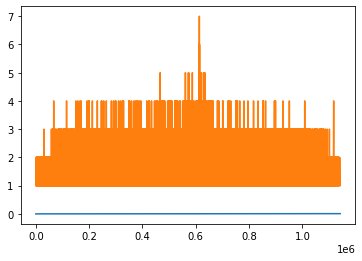

In [34]:
print(len(fc5))
print(np.count_nonzero(fc5))
print(len(np.intersect1d(fb1, fc5)))
print(len(np.where(fc5>fb1-0.0001)[0]))
print(len(np.where(fc5==fb1)[0]))

import matplotlib.pyplot as plt
df5 = fc5 - fb1
unique, counts = np.unique(df5, return_counts=True)
npc = np.asarray((unique, counts)).T
print(np.amax(df5))

plt.plot(npc)
plt.show()

In [ ]:
'''
def sub_model(model1, model2):
    params1 = model1.state_dict().copy()
    params2 = model2.state_dict().copy()
    
    params1['conv1.weight'] = params2['conv1.weight']
    #params1['fc1.weight'] = params2['fc1.weight']
    
    model = copy.deepcopy(model1)
    model.load_state_dict(params1, strict=False)
    return model

_C1_ = copy.deepcopy(_C1)
_C1_ = sub_model(_B1, _C1_)

_C2_ = copy.deepcopy(_C2)
_C2_ = sub_model(_B1, _C2_)

#print(sim.grad_cosine_similarity(_B1, _C1_))
#print(sim._grad_cosine_similarity(_B1, _C1_))

avgargs = {"base_update": _B1}
t1 = fl.federated_avg({'a': _C1, 'b': _C2, 'c': _C3, 'd': _C4, 'e': _C5}, B1, agg.Rule.FLTrust, **avgargs)
t2 = fl.federated_avg({'a': _C1_, 'b': _C2_, 'c': _C3, 'd': _C4, 'e': _C5}, B1, agg.Rule.FLTrust, **avgargs)

print(fl.eval(t1, test_loader, device))
print(fl.eval(t2, test_loader, device))
'''

In [36]:
'''
model=nn.denoising_model().to(device)
criterion=torch.nn.MSELoss()
optimizer=optim.SGD(model.parameters(),lr=0.5,weight_decay=1e-5)

output = fc1
model.train()
for epcoh in range(10):
    optimizer.zero_grad()
    output = model(torch.from_numpy(fc1))
    cs1 = mnd.dot(mnd.array(fb1), mnd.array(output.detach().numpy())) / (mnd.norm(mnd.array(fb1)) + 1e-9) / (mnd.norm(mnd.array(output.detach().numpy())) + 1e-9)
    _loss = criterion(output, torch.from_numpy(fb1))
    _loss = _loss + (1 - cs1.asnumpy()[0])
    print(_loss)
    _loss.backward()
    optimizer.step()
'''

'\nmodel=nn.denoising_model().to(device)\ncriterion=torch.nn.MSELoss()\noptimizer=optim.SGD(model.parameters(),lr=0.5,weight_decay=1e-5)\n\noutput = fc1\nmodel.train()\nfor epcoh in range(10):\n    optimizer.zero_grad()\n    output = model(torch.from_numpy(fc1))\n    cs1 = mnd.dot(mnd.array(fb1), mnd.array(output.detach().numpy())) / (mnd.norm(mnd.array(fb1)) + 1e-9) / (mnd.norm(mnd.array(output.detach().numpy())) + 1e-9)\n    _loss = criterion(output, torch.from_numpy(fb1))\n    _loss = _loss + (1 - cs1.asnumpy()[0])\n    print(_loss)\n    _loss.backward()\n    optimizer.step()\n'

In [93]:
b = [1, 1, 1]
g = [1, 2, 3]
#b-g = [0, 1, 2]

In [94]:
import time
start_time = time.time()

m = copy.deepcopy(g)
dot_bm = sim.dot(b, m)
norm_m = sim.norm(m)
norm_g = sim.norm(g)
sim_mg = sim.cosine_similarity(m, g)

print(sim_bg)

for coord in reversed(range(len(b))):
    m, dot_bm, norm_m, sim_mg = sim.cosine_coord_vector_adapter(b, m, coord, dot_bm, norm_m, sim_mg, g, norm_g)
    
    print(sim.cosine_similarity(b, m), sim.cosine_similarity(g, m))
    print(m)

print(time.time() - start_time)

0.9258202
0.92582 0.8367346
[1, 2, 0.8181812470752238]
0.9258199 0.8205977
[1, 0.3140487202791258, 0.8181812470752238]
0.9258199 0.8205977
[1, 0.3140487202791258, 0.8181812470752238]
0.018163681030273438


In [423]:
from pyhessian import hessian

In [429]:
criterion = torch.nn.CrossEntropyLoss()
for inputs, targets in root_loader:
    break
hessian_comp = hessian(_B1, criterion, data=(inputs, targets), cuda=False)

In [430]:
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()

In [434]:
tev = top_eigenvector[0]
tev = tev.unsqueeze(0)
print(tev.shape)
#tev, tevlist = sim.get_net_arr(top_eigenvector[0])

AttributeError: 'list' object has no attribute 'unsqueeze'